# Project: Instance-Based (k-Nearest Neighbors (kNN))
## Name: Melody Goldanloo

The Heart Disease dataset contains 303 instances with 14 features each, such as age, sex, chest pain type, resting blood pressure, serum cholesterol, fasting blood sugar, resting electrocardiographic results, maximum heart rate achieved, exercise-induced angina, oldpeak, the slope of the peak exercise ST segment, number of major vessels, and thalassemia.
The target variable is the presence (1-4) or absence (0) of heart disease.

In [2]:
#Example of supress warnings for Numpy version out of range (optional)
import warnings
warnings.filterwarnings("ignore", category=Warning)
warnings.simplefilter(action='ignore', category=FutureWarning)

#Some recommended libraries
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np

%matplotlib inline

# The Dataset

In [3]:
# Load the Heart Disease dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
column_names = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach",
    "exang", "oldpeak", "slope", "ca", "thal", "target"
]
df = pd.read_csv(url, names=column_names, na_values='?')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


# Data Preprocessing

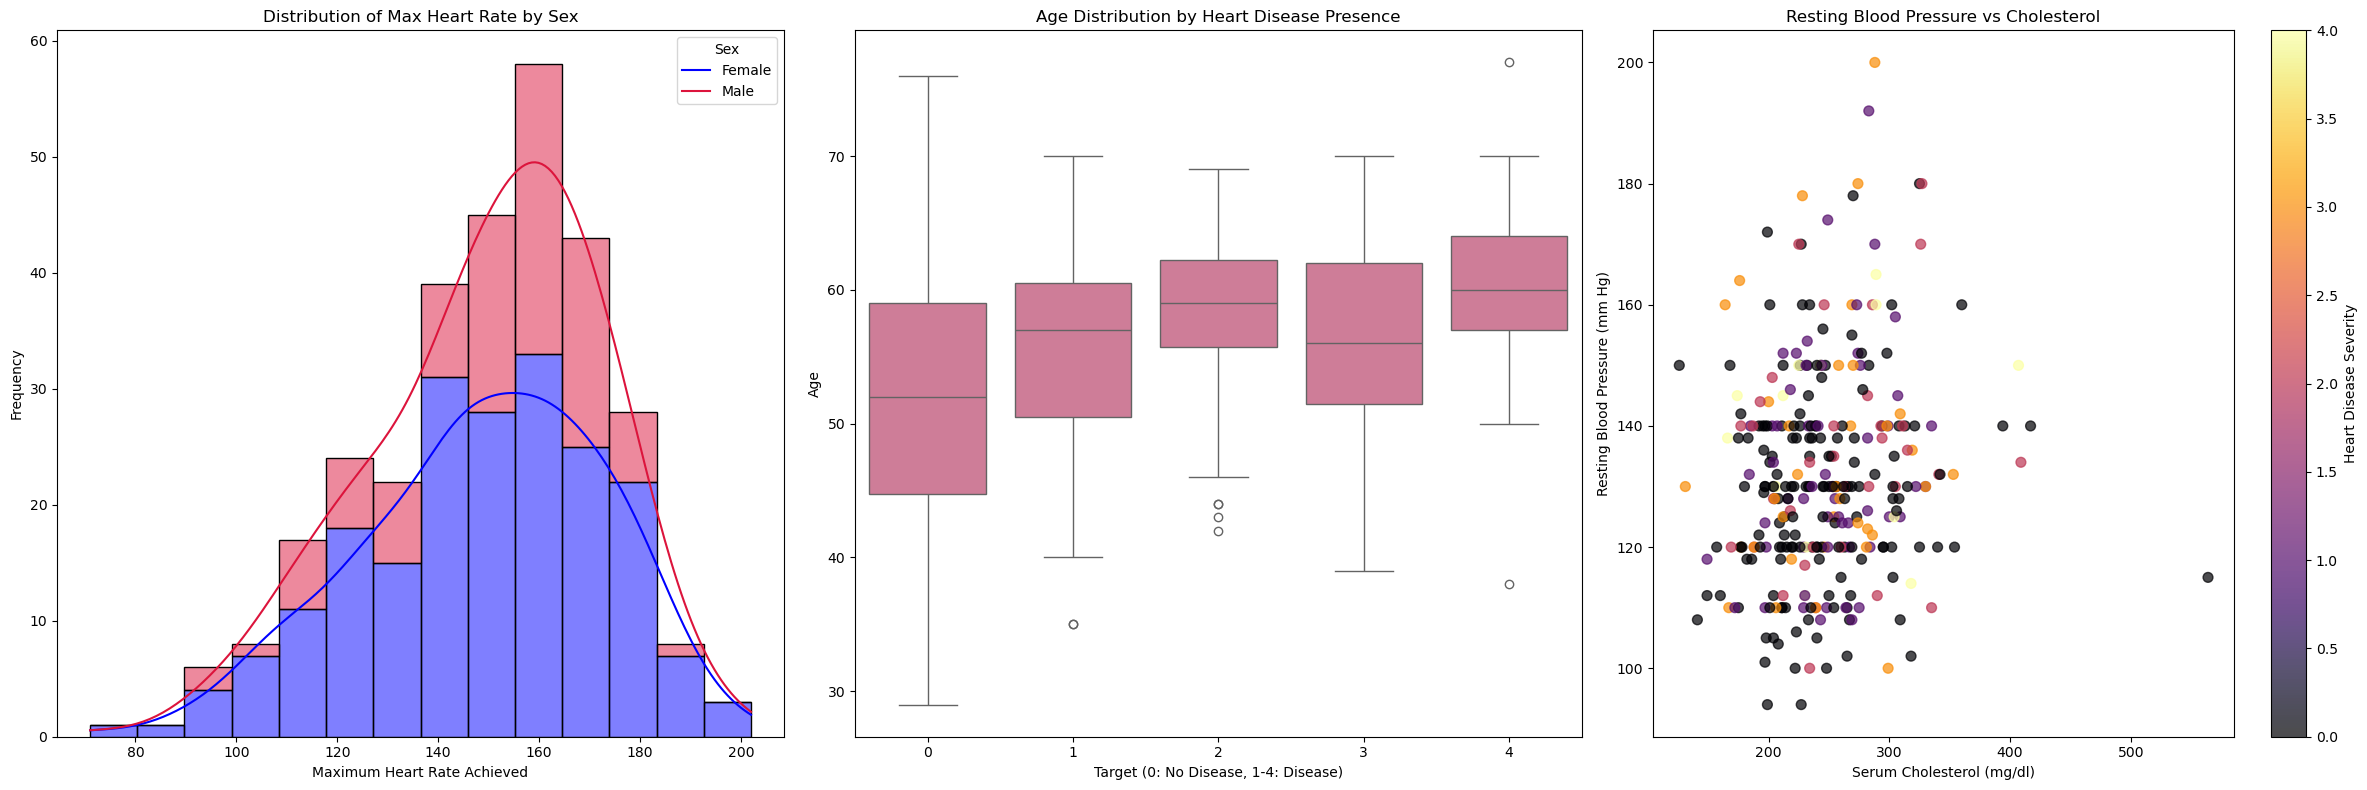

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  target    303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB


(              age         sex          cp    trestbps        chol         fbs  \
 count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
 mean    54.438944    0.679868    3.158416  131.689769  246.693069    0.148515   
 std      9.038662    0.467299    0.960126   17.599748   51.776918    0.356198   
 min     29.000000    0.000000    1.000000   94.000000  126.000000    0.000000   
 25%     48.000000    0.000000    3.000000  120.000000  211.000000    0.000000   
 50%     56.000000    1.000000    3.000000  130.000000  241.000000    0.000000   
 75%     61.000000    1.000000    4.000000  140.000000  275.000000    0.000000   
 max     77.000000    1.000000    4.000000  200.000000  564.000000    1.000000   
 
           restecg     thalach       exang     oldpeak       slope          ca  \
 count  303.000000  303.000000  303.000000  303.000000  303.000000  299.000000   
 mean     0.990099  149.607261    0.326733    1.039604    1.600660    0.672241   
 std      0.99

In [4]:
#Exploration and Visualization
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

sns.histplot(data=df, x='thalach', hue='sex', kde=True, palette=['crimson', 'blue'], multiple="stack", ax=ax1)
ax1.set_title('Distribution of Max Heart Rate by Sex')
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Maximum Heart Rate Achieved')
ax1.legend(labels=['Female', 'Male'], title='Sex')

sns.boxplot(x='target', y='age', data=df, color='palevioletred', ax=ax2)
ax2.set_title('Age Distribution by Heart Disease Presence')
ax2.set_xlabel('Target (0: No Disease, 1-4: Disease)')
ax2.set_ylabel('Age')

scatter = ax3.scatter(df['chol'], df['trestbps'], c=df['target'], 
                      cmap='inferno', alpha=0.7, s=50)
ax3.set_title('Resting Blood Pressure vs Cholesterol')
ax3.set_xlabel('Serum Cholesterol (mg/dl)')
ax3.set_ylabel('Resting Blood Pressure (mm Hg)')
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('Heart Disease Severity')

plt.tight_layout()
plt.show()

df.describe(), df.info()

In [5]:
# Checking for missing values
df.isnull().sum()
# only 6 missing values total, so we can drop them
df = df.dropna()

# There are is only one categorical variable, so we don't need to encode them

# Standardize the features
df_scaled = df[column_names].copy()
scaler = StandardScaler()
df_scaled[['age', 'trestbps', 'chol', 'restecg', 'thalach', 'oldpeak']] = scaler.fit_transform(df_scaled[['age', 'trestbps', 'chol', 'restecg', 'thalach', 'oldpeak']])

df_scaled.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0.936181,1.0,1.0,0.750380,-0.276443,1.0,1.010199,0.017494,0.0,1.068965,3.0,0.0,6.0,0
1,1.378929,1.0,4.0,1.596266,0.744555,0.0,1.010199,-1.816334,1.0,0.381773,2.0,3.0,3.0,2
2,1.378929,1.0,4.0,-0.659431,-0.353500,0.0,1.010199,-0.899420,1.0,1.326662,2.0,2.0,7.0,1
3,-1.941680,1.0,3.0,-0.095506,0.051047,0.0,-1.003419,1.633010,0.0,2.099753,3.0,0.0,3.0,0
4,-1.498933,0.0,2.0,-0.095506,-0.835103,0.0,1.010199,0.978071,0.0,0.295874,1.0,0.0,3.0,0


In [6]:
# Training and Testing Sets
X = df_scaled[['age', 'sex', 'trestbps', 'chol', 'restecg', 'thalach', 'oldpeak']]
y = df_scaled['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Building the kNN Model
**Model Initialization:**

**Choosing Hyperparameters:** Explain key hyperparameters such as the number of neighbors (n_neighbors), the distance metric (metric), and the weight function (weights).

**KNN Initialization:** Use the KNeighborsClassifier class from Scikit-learn, specifying the chosen hyperparameters.

**Model Fitting:** Fit the KNN model to the standardized Heart Disease dataset.

In [7]:
#Building the model
knn = KNeighborsClassifier(n_neighbors=3, metric='euclidean', weights='uniform')
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Classification Accuracy: {accuracy:.2f}")

Classification Accuracy: 0.53


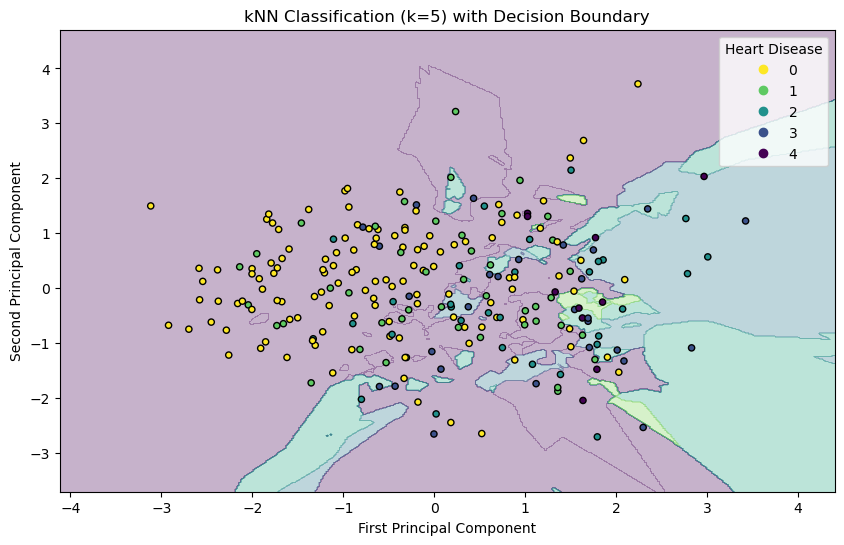

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

knn_pca = KNeighborsClassifier(n_neighbors=5, metric='euclidean', weights='uniform')
knn_pca.fit(X_train_pca, y_train)

h = .02  # step size in the mesh
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

#Predict for each point in the mesh grid
Z = knn_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

#Plot the decision boundary and scatter plot
plt.figure(figsize=(10, 6))
cmap_light = ListedColormap(['#440154', '#414487', '#2a788e', '#22a884', '#7ad151'])
cmap_bold = ListedColormap(['#fde725', '#5ec962', '#21918c', '#3b528b', '#440154'])
plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_light)

#Plot the scatter points and add a legend
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=cmap_bold, edgecolor='k', s=20)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('kNN Classification (k=5) with Decision Boundary')
plt.legend(*scatter.legend_elements(), title="Heart Disease")
plt.show()

# Set # of neighbors to 5 because 3 was overfitting. Still not perfect, but better.

# Evaluating the Model
**Performance Metrics:** Calculate metrics such as accuracy, precision, recall, F1 score, and confusion matrix to evaluate the model. These metrics provide insights into the model’s predictive performance and its ability to generalize.

In [9]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification Accuracy: {accuracy:.2f}")

precision = precision_score(y_test, y_pred, average='macro')
print(f"Precision: {precision:.2f}")

recall = recall_score(y_test, y_pred, average='macro')
print(f"Recall: {recall:.2f}")

Classification Accuracy: 0.53
Precision: 0.22
Recall: 0.22


## For the Model Selection Project, you will STOP HERE! 
During Units 4, 5, and 6, we will explore and learn additional techniques, and then revisit these projects to apply the below:
- Model evaluation and parameter tuning
- Explanatory visualizations and package your results with data storytelling

# Tuning Model Parameters (Completed in Unit 4)

In [ ]:
#Insert Code Here

# Evaluating the Tuned Model (Completed in Unit 4)

In [ ]:
#Insert Code Here

# Visualizing Results (Completed in Units 4 and 6)

In [ ]:
#Insert Code Here